#Exercise sheet

Cristina Acevedo 


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


random.seed(3116)
np.random.seed(3116)

Exercise 0: Dataset preprocessing

In [3]:
data=pd.read_table('tic-tac-toe.data', header=None, delimiter=',')#Load data
data.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [4]:
#Convert any non-numeric values to numeric values.

data=data.replace(['x','o', 'b','positive','negative'],[1, -1, 0, 1, 0]).rename(columns={9: "class"}) #Replace non numeric values and rename results

In [5]:
#This dataset is unbalanced, (show how we can confirm this)
data['class'].value_counts() #There are many more examples of class positive than class negative

#A stratified sampler will divide the data by class and then randomly sample from each class the same number of elements
#thus we obtain groups of the same size for each one of the classes

1    626
0    332
Name: class, dtype: int64

In [6]:
#Implement a stratified sampler.

def stratifiedsampler(data, column, class_values, sample_size):
  result = data[0:0]
  
  for i in class_values:
    filtered_data=data[data[column]==i].reset_index(drop=True) #Get data from i class_value
    idx=random.sample(range(len(filtered_data)), sample_size) #Get random index
    for j in idx:
      result=result.append(filtered_data.iloc[j,:]) #Save the selected sample
  result.reset_index(drop=True) #Reset index result
  return result

newdata=stratifiedsampler(data, 'class', [1, 0], 200)

In [7]:
#Split the data into a train(80%) and test(20%)

n=list(range(len(newdata)))#Get indexes of newdata
random.shuffle(n) #Shuffle the order 

limit=round(len(n)/100*80)
train=n[0:limit] #Get first 80% indexes for training
test=n[limit:] #Get 20% indexes left for testing

data_train=newdata.iloc[train].to_numpy() #Distribute dataset
data_test=newdata.iloc[test].to_numpy() #Distribute dataset

y_train=data_train[:,-1]
x_train=data_train[:,0:-1]
y_test=data_test[:,-1]
x_test=data_test[:,0:-1]

Exercise 1: Logistic Regression with Gradient Descent

In [8]:
#Implement learn-logreg-GA. Choose imax between 100 to 1000
#You will use bolddriver as the step length controller.

def learn_logreg_GA(x, y, mu, tmax, eps):
  beta=np.zeros(len(x[0])) #Initialize beta as 0's
  allbetas=beta #Save beta's current value
  l=loss_function(x,y,beta) #Calculate loss
  losses=np.array([l]) #Create array to store losses
  logloss=[] #Create array to store log losses
  for i in range(tmax):
    yhat=logistic_reg(x, beta) #Calculate y from x and beta with logistic regression
    logloss.append(log_loss(y, yhat)) #Save logloss

    mu=bolddriver(x,y,beta,mu,1.1,0.5) #Calculate mu from bolddriver
    oldbeta=beta

    beta=beta+mu*loss_derivative(x,y,beta) #Calculate new beta with gradient ascent
    allbetas=np.vstack([allbetas, beta]) #Save beta's value
    losses=np.vstack([losses, abs(loss_function(x,y,beta)-loss_function(x,y,oldbeta))]) #Save loss difference
    
    l_old=l
    l=loss_function(x,y,beta)
    if l-l_old<eps:
      return allbetas, losses, logloss

  raise Exception(f'not converged in {tmax} iterations')


#Adapt to logistic regression
def bolddriver(x,y,beta, mu, muincrease, mudecrease):
  new_beta=beta+mu*-loss_derivative(x,y,beta)
  improvement=False
  old_loss=loss_function(x,y,beta)
  new_loss=loss_function(x,y,new_beta)
  if old_loss>new_loss: #While it's not improving, make shorter step
    while improvement==0:
      mu=mu*mudecrease
      new_beta=beta+mu*-loss_derivative(x,y,beta)
      old_loss=loss_function(x,y,beta)
      new_loss=loss_function(x,y,new_beta)
      if old_loss>new_loss:
        improvement=True
        return mu
  else: #If direction is right, make a bigger step
    improvement=True
    while improvement==True:
      mu=mu*muincrease
      new_beta=beta+mu*-loss_derivative(x,y,beta)
      old_loss=loss_function(x,y,beta)
      new_loss=loss_function(x,y,new_beta)
      if old_loss>new_loss:
        improvement=False
        return mu


def loss_function(x,y,beta):
  return sum(np.dot(y,np.dot(x,beta))-np.log(1+np.e**(np.dot(x,beta))))

def logistic_reg(xs, betas):
  return 1/(1+np.e**(-np.dot(xs,betas)))

def loss_derivative(x,y,beta):
  yhat=logistic_reg(x,beta)
  return np.dot(np.transpose(x),(y-yhat))

#Link in exercise sheet didn't work, so I used https://www.kaggle.com/ikennaanigbogu/understanding-logloss instead
def log_loss(y, y_hat, eps=1e-15):
  p=np.clip(y_hat, eps, 1-eps) #Limits the range of predictions and makes sure we never take log(0)
  answer=0
  for i in range(len(y)):
    if y[i] ==1:
      answer=answer-np.log(p[i])
    else:
      answer=answer-np.log(1-p[i])
  return answer
 

In [9]:
betas, lossdifference, logloss=learn_logreg_GA(x_train,y_train,0.01,1000,0.001)

Text(0, 0.5, '$l(beta_i)-l(beta_{i+1})$')

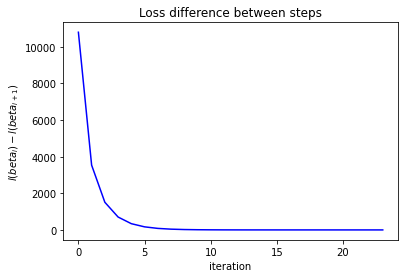

In [10]:
plt.plot(lossdifference[1:],'b') 
plt.title('Loss difference between steps')
plt.xlabel('iteration')
plt.ylabel('$l(beta_i)-l(beta_{i+1})$')
#The difference in loss between steps gets smaller with every iteration.
#This means, as we approach the optimal solution, the improvements are diminishing
#until they are very small and more steps will no longer improve the results

Text(0, 0.5, 'Log loss(beta)')

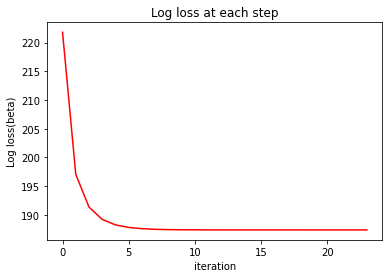

In [11]:
plt.plot(logloss,'r')
plt.title('Log loss at each step')
plt.xlabel('iteration')
plt.ylabel('Log loss(beta)')
#The log loss should be getting smaller with every step, which is true for this case
#As the likelihood is a gain function, log loss may be used instead to find minimum value
#As we iterate, the log loss gets smaller, so the results of the model improve
#In the end, improvements get smaller until we decide to stop the learning algorithm.

In [12]:
def min_newton(x,y,beta,mu, tmax, eps):
  losses=[]
  logloss=[]
  for i in range(tmax):
    g=nabla(x,y,beta) #Calculate derivative
    h=hessian(x,y,beta) #Calculate hessian
    old_beta=beta #Save old beta before calculating new one

    beta=beta+mu*np.dot(np.linalg.inv(h),g) #Calculate next beta

    losses.append(sum(f(x,y,old_beta))-sum(f(x,y,beta))) #Save loss difference
    logloss.append(sum(f(x,y,beta))) #Save logloss

    if sum(f(x,y,old_beta))-sum(f(x,y,beta))<eps: #Stop if improvement is not significant
      return beta, losses, logloss
  raise Exception("maximum iterations limit") 

def f(x,y,beta): #Log likelihood function
  return np.dot(y,np.dot(x,beta))-np.log(1+np.e**(np.dot(x,beta)))

def nabla(x,y,beta): #Log likelihood derivative
  yhat=logistic_reg(x,beta) #Calculate y from x and beta
  return np.dot(np.transpose(x),(y-yhat))

def hessian(x,y,beta): #Log likelihood hessian
  yhat=logistic_reg(x,beta) #Calculate y from x and beta
  w=f(x,yhat,beta)*(1-f(x,yhat,beta)) #Get diagonal terms
  return np.dot(np.transpose(x),np.dot(np.diag(w),x)) #Calculate 

def learn_log_reg(x,y,mu,tmax,eps):
  #Define beta
  beta=np.zeros(len(x[0])) #Initialize beta as 0's
  beta, losses, logloss=min_newton(x,y,beta,mu,tmax,eps) #Call minimizing function
  return beta, losses, logloss

def log_loss(y, y_hat, eps=1e-15):
  p=np.clip(y_hat, eps, 1-eps) #Limits the range of predictions and makes sure we never take log(0)
  answer=0
  for i in range(len(y)):
    if y[i] ==1:
      answer=answer-np.log(p[i]) #If answer is 1 substract log of probability
    else:
      answer=answer-np.log(1-p[i]) #Is answer is 0 substract log of 1-probability
  return answer

def logistic_reg(xs, betas):
  return np.e**(np.dot(xs,betas))/(1+np.e**(np.dot(xs,betas))) #Function sigma(z) for logistic regression

In [13]:
beta, losses, logloss=learn_log_reg(x_train,y_train,0.01,1000,10)

Text(0, 0.5, '$l(beta_i)-l(beta_{i+1})$')

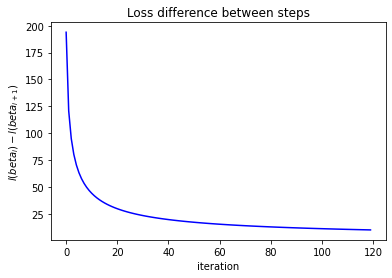

In [14]:
plt.plot(losses ,'b')
plt.title('Loss difference between steps')
plt.xlabel('iteration')
plt.ylabel('$l(beta_i)-l(beta_{i+1})$')

#This algorithm takes longer to find the minimum and stop
#The difference is at first large, but gets smaller with every step
#In the end, it gets very close to 0 and finishes
#As this algorithm takes longer to converge, I took a larger eps to obtain an answer within 1000 iterations

Text(0, 0.5, 'Log loss(beta)')

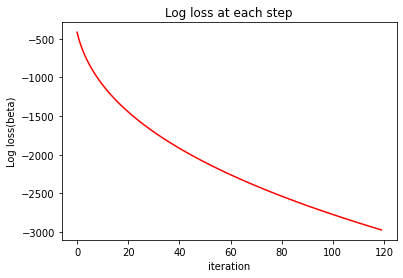

In [15]:
plt.plot(logloss, 'r')
plt.title('Log loss at each step')
plt.xlabel('iteration')
plt.ylabel('Log loss(beta)')

#The log loss in this case is diminishing at a slower rate than with the previous algorithm
#However, it is being minimized at every iteration, which means the betas are beign improved
#The convergence is not as good as the previous one possibly because of the larger eps